In [1]:
import numpy as np
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm
import requests
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

%matplotlib inline

## Prepare Data
Add the Zillow Housing Values Data and filter it to focus on Colorado (Outside of Denver Metro Area). 

In [2]:
df = pd.read_csv('zillowfcast.csv', header=0)
df.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
0,6181,0,New York,City,NY,NY,New York-Newark-Jersey City,Queens County,190398.0,189850.0,...,634054.0,634278.0,633853.0,634318.0,634515.0,636021.0,637194.0,639617.0,642143.0,645143.0
1,12447,1,Los Angeles,City,CA,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,184549.0,184526.0,...,728217.0,734778.0,741304.0,747043.0,749468.0,751337.0,758225.0,767969.0,779202.0,788122.0
2,39051,2,Houston,City,TX,TX,Houston-The Woodlands-Sugar Land,Harris County,93996.0,94111.0,...,191067.0,191548.0,192467.0,193609.0,194580.0,195274.0,196053.0,196951.0,198489.0,199976.0
3,17426,3,Chicago,City,IL,IL,Chicago-Naperville-Elgin,Cook County,139984.0,139826.0,...,264568.0,265130.0,266031.0,266788.0,267648.0,268834.0,270837.0,273295.0,276572.0,279986.0
4,6915,4,San Antonio,City,TX,TX,San Antonio-New Braunfels,Bexar County,97472.0,97437.0,...,193078.0,193243.0,193916.0,194255.0,194823.0,195380.0,196299.0,197446.0,198886.0,200621.0
5,13271,5,Philadelphia,City,PA,PA,Philadelphia-Camden-Wilmington,Philadelphia County,71557.0,71465.0,...,187752.0,188564.0,189738.0,191377.0,192682.0,194257.0,196097.0,198763.0,201278.0,204082.0
6,40326,6,Phoenix,City,AZ,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,96887.0,97180.0,...,260629.0,262663.0,265012.0,268310.0,271333.0,274251.0,277160.0,280802.0,285116.0,289769.0
7,18959,7,Las Vegas,City,NV,NV,Las Vegas-Henderson-Paradise,Clark County,147000.0,146880.0,...,282618.0,283364.0,285328.0,286988.0,288019.0,288415.0,289716.0,292388.0,296085.0,299020.0
8,54296,8,San Diego,City,CA,CA,San Diego-Carlsbad,San Diego County,187934.0,187552.0,...,644706.0,648568.0,653221.0,656557.0,660877.0,663602.0,667352.0,673456.0,682932.0,693605.0
9,38128,9,Dallas,City,TX,TX,Dallas-Fort Worth-Arlington,Dallas County,100144.0,100140.0,...,222779.0,222643.0,222969.0,224077.0,225513.0,227117.0,228985.0,230732.0,232919.0,236652.0


In [3]:
# create dataframe filtered on Colorado to narrow the data frame

is_co = df['StateName']=='CO'
print(is_co.head())


0    False
1    False
2    False
3    False
4    False
Name: StateName, dtype: bool


In [4]:
# new colorado only dataframe 
df_co = pd.DataFrame(df[is_co])
df_co.shape


(400, 306)

In [26]:
df_co.sort_values('SizeRank').head(30)

,index,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate,gcode,Lat,Lon
0,375,31819,380,Grand Junction,City,CO,Colorado,Grand Junction,Mesa County,107650.0,...,265653.0,267109.0,268958.0,271020.0,272388.0,274229.0,"Grand Junction, Mesa County, Colorado","(Grand Junction, Mesa County, Colorado, United...",39.063956,-108.550732
1,401,11695,407,Greeley,City,CO,Colorado,Greeley,Weld County,135095.0,...,336996.0,338121.0,339682.0,340987.0,342985.0,345203.0,"Greeley, Weld County, Colorado","(Greeley, Weld County, Colorado, United States...",40.423314,-104.709132
2,1664,11179,1699,Durango,City,CO,Colorado,Durango,La Plata County,NaN,...,454210.0,455794.0,458998.0,461168.0,464640.0,468360.0,"Durango, La Plata County, Colorado","(Durango, La Plata County, Colorado, United St...",37.271395,-107.881598
3,1681,12817,1716,Montrose,City,CO,Colorado,Montrose,Montrose County,106842.0,...,295222.0,295900.0,296638.0,297474.0,298473.0,299945.0,"Montrose, Montrose County, Colorado","(Montrose, Montrose County, Colorado, 81401, U...",38.478193,-107.876277
4,2215,3958,2276,Canon City,City,CO,Colorado,Cañon City,Fremont County,NaN,...,240218.0,239282.0,239732.0,239411.0,239582.0,238913.0,"Canon City, Fremont County, Colorado","(Cañon City, Fremont County, Colorado, 81212, ...",38.442364,-105.222495
5,2824,51948,2916,Evans,City,CO,Colorado,Greeley,Weld County,104892.0,...,307599.0,308568.0,309822.0,311035.0,312832.0,314606.0,"Evans, Weld County, Colorado","(Evans, Weld County, Colorado, United States, ...",40.376370,-104.692187
6,3104,38414,3213,Erie,City,CO,Colorado,Greeley,Weld County,193953.0,...,563233.0,565742.0,569003.0,572239.0,576080.0,580875.0,"Erie, Weld County, Colorado","(Erie, Weld County, Colorado, 80516, United St...",40.050262,-105.049982
7,3149,20642,3260,Steamboat Springs,City,CO,Colorado,Steamboat Springs,Routt County,196113.0,...,660203.0,659121.0,660488.0,665465.0,670768.0,679042.0,"Steamboat Springs, Routt County, Colorado","(Steamboat Springs, Routt County, Colorado, Un...",40.484800,-106.831736
8,3233,20651,3349,Sterling,City,CO,Colorado,Sterling,Logan County,68999.0,...,179054.0,179303.0,179549.0,179862.0,180273.0,180777.0,"Sterling, Logan County, Colorado","(Sterling, Logan County, Colorado, 80751, Unit...",40.625541,-103.207709
9,3260,4776,3379,Fort Morgan,City,CO,Colorado,Fort Morgan,Morgan County,77647.0,...,223572.0,224132.0,224609.0,225033.0,225409.0,225858.0,"Fort Morgan, Morgan County, Colorado","(Fort Morgan, Morgan County, Colorado, United ...",40.250258,-103.799951


In [27]:
#Drop larger metro areas since focus is on small/med towns

df_co = df_co[~df_co['Metro'].isin(['Denver-Aurora-Lakewood', 'Boulder', 'Fort Collins', 'Colorado Springs', 'Pueblo', 'Greeley'])]
              
              




In [28]:
df_co

,index,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate,gcode,Lat,Lon
0,375,31819,380,Grand Junction,City,CO,Colorado,Grand Junction,Mesa County,107650.0,...,265653.0,267109.0,268958.0,271020.0,272388.0,274229.0,"Grand Junction, Mesa County, Colorado","(Grand Junction, Mesa County, Colorado, United...",39.063956,-108.550732
2,1664,11179,1699,Durango,City,CO,Colorado,Durango,La Plata County,NaN,...,454210.0,455794.0,458998.0,461168.0,464640.0,468360.0,"Durango, La Plata County, Colorado","(Durango, La Plata County, Colorado, United St...",37.271395,-107.881598
3,1681,12817,1716,Montrose,City,CO,Colorado,Montrose,Montrose County,106842.0,...,295222.0,295900.0,296638.0,297474.0,298473.0,299945.0,"Montrose, Montrose County, Colorado","(Montrose, Montrose County, Colorado, 81401, U...",38.478193,-107.876277
4,2215,3958,2276,Canon City,City,CO,Colorado,Cañon City,Fremont County,NaN,...,240218.0,239282.0,239732.0,239411.0,239582.0,238913.0,"Canon City, Fremont County, Colorado","(Cañon City, Fremont County, Colorado, 81212, ...",38.442364,-105.222495
7,3149,20642,3260,Steamboat Springs,City,CO,Colorado,Steamboat Springs,Routt County,196113.0,...,660203.0,659121.0,660488.0,665465.0,670768.0,679042.0,"Steamboat Springs, Routt County, Colorado","(Steamboat Springs, Routt County, Colorado, Un...",40.484800,-106.831736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,24975,47188,29449,Poncha Springs,City,CO,Colorado,NaN,Chaffee County,NaN,...,309436.0,309983.0,310457.0,311004.0,311275.0,311745.0,"Poncha Springs, Chaffee County, Colorado","(Poncha Springs, Chaffee County, Colorado, 812...",38.513969,-106.075332
259,25241,56562,29449,Williamsburg,City,CO,Colorado,Cañon City,Fremont County,NaN,...,182013.0,181907.0,182478.0,182297.0,182618.0,182326.0,"Williamsburg, Fremont County, Colorado","(Williamsburg, Fremont County, Colorado, Unite...",38.381944,-105.151933
260,25626,5100,29449,Haxtun,City,CO,Colorado,NaN,Phillips County,NaN,...,113964.0,113991.0,114590.0,115265.0,115870.0,116516.0,"Haxtun, Phillips County, Colorado","(Haxtun, Phillips County, Colorado, 80731, Uni...",40.641102,-102.626858
261,25801,20169,29449,Rico,City,CO,Colorado,NaN,Dolores County,NaN,...,282955.0,281988.0,280692.0,280922.0,280722.0,280886.0,"Rico, Dolores County, Colorado","(Rico, Dolores County, Colorado, United States...",37.692686,-108.031502


Now let's add in a concatenated address column to support more accurate geocoding results, given we do not have street addresses to leverage.

In [12]:
# add column with county and full statename for better geocoding
df_co['State'] = df_co['State'].replace(['CO'],'Colorado')
df_co['citystate'] = df_co['RegionName'].astype(str) + ', ' + \
        df_co['CountyName'].astype(str) + ', ' + \
        df_co['State'] 

df_co.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate
375,31819,380,Grand Junction,City,CO,Colorado,Grand Junction,Mesa County,107650.0,107972.0,...,261728.0,263850.0,265254.0,265653.0,267109.0,268958.0,271020.0,272388.0,274229.0,"Grand Junction, Mesa County, Colorado"
401,11695,407,Greeley,City,CO,Colorado,Greeley,Weld County,135095.0,135790.0,...,332806.0,334160.0,335503.0,336996.0,338121.0,339682.0,340987.0,342985.0,345203.0,"Greeley, Weld County, Colorado"
1664,11179,1699,Durango,City,CO,Colorado,Durango,La Plata County,NaN,NaN,...,458854.0,455431.0,452199.0,454210.0,455794.0,458998.0,461168.0,464640.0,468360.0,"Durango, La Plata County, Colorado"
1681,12817,1716,Montrose,City,CO,Colorado,Montrose,Montrose County,106842.0,107189.0,...,293171.0,293896.0,294655.0,295222.0,295900.0,296638.0,297474.0,298473.0,299945.0,"Montrose, Montrose County, Colorado"
2215,3958,2276,Canon City,City,CO,Colorado,Cañon City,Fremont County,NaN,NaN,...,239378.0,240159.0,240605.0,240218.0,239282.0,239732.0,239411.0,239582.0,238913.0,"Canon City, Fremont County, Colorado"


In [ ]:
#df_co.set_index('SizeRank', inplace=True)


In [ ]:
#df_co.columns
#print(df_co.shape)

Now we will set up GeoPy's Nominatim package to generate lat, long for each city in our data frame.  First we will test on Grand Junction and the state of Colorado 

In [13]:
# create user_agent to identify lat/long coordinates per city
address = "Grand Junction, Mesa County, Colorado"

geolocator = Nominatim(timeout=5, user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

39.063956 -108.5507317


In [15]:
# Retrieving colorado lat/long for use in Folium Maps 
co_address = "Colorado, United States"

location2 = geolocator.geocode(co_address)
latitude2 = location2.latitude
longitude2 = location2.longitude
print(latitude2, longitude2)

38.7251776 -105.6077167


In [16]:
# geocoding each city in the dataframe
df_co['gcode'] = df_co.citystate.apply(geolocator.geocode)

In [17]:
#extracting the lat and long into separate columns
df_co['Lat'] = df_co['gcode'].apply(lambda x: x.latitude if x else None)
df_co['Lon'] = df_co['gcode'].apply(lambda x: x.longitude if x else None)
 
df_co.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,1996-02-29,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate,gcode,Lat,Lon
24975,47188,29449,Poncha Springs,City,CO,Colorado,NaN,Chaffee County,NaN,NaN,...,309436.0,309983.0,310457.0,311004.0,311275.0,311745.0,"Poncha Springs, Chaffee County, Colorado","(Poncha Springs, Chaffee County, Colorado, 812...",38.513969,-106.075332
25241,56562,29449,Williamsburg,City,CO,Colorado,Cañon City,Fremont County,NaN,NaN,...,182013.0,181907.0,182478.0,182297.0,182618.0,182326.0,"Williamsburg, Fremont County, Colorado","(Williamsburg, Fremont County, Colorado, Unite...",38.381944,-105.151933
25626,5100,29449,Haxtun,City,CO,Colorado,NaN,Phillips County,NaN,NaN,...,113964.0,113991.0,114590.0,115265.0,115870.0,116516.0,"Haxtun, Phillips County, Colorado","(Haxtun, Phillips County, Colorado, 80731, Uni...",40.641102,-102.626858
25801,20169,29449,Rico,City,CO,Colorado,NaN,Dolores County,NaN,NaN,...,282955.0,281988.0,280692.0,280922.0,280722.0,280886.0,"Rico, Dolores County, Colorado","(Rico, Dolores County, Colorado, United States...",37.692686,-108.031502
25853,22690,29449,Woody Creek,City,CO,Colorado,Glenwood Springs,Pitkin County,NaN,NaN,...,487123.0,488786.0,489187.0,487962.0,486693.0,485434.0,"Woody Creek, Pitkin County, Colorado","(Woody Creek, Pitkin County, Colorado, 81656, ...",39.270263,-106.886152


In [18]:
df_co.reset_index(inplace=True)
df_co.head()

,index,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,1996-01-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,citystate,gcode,Lat,Lon
0,375,31819,380,Grand Junction,City,CO,Colorado,Grand Junction,Mesa County,107650.0,...,265653.0,267109.0,268958.0,271020.0,272388.0,274229.0,"Grand Junction, Mesa County, Colorado","(Grand Junction, Mesa County, Colorado, United...",39.063956,-108.550732
1,401,11695,407,Greeley,City,CO,Colorado,Greeley,Weld County,135095.0,...,336996.0,338121.0,339682.0,340987.0,342985.0,345203.0,"Greeley, Weld County, Colorado","(Greeley, Weld County, Colorado, United States...",40.423314,-104.709132
2,1664,11179,1699,Durango,City,CO,Colorado,Durango,La Plata County,NaN,...,454210.0,455794.0,458998.0,461168.0,464640.0,468360.0,"Durango, La Plata County, Colorado","(Durango, La Plata County, Colorado, United St...",37.271395,-107.881598
3,1681,12817,1716,Montrose,City,CO,Colorado,Montrose,Montrose County,106842.0,...,295222.0,295900.0,296638.0,297474.0,298473.0,299945.0,"Montrose, Montrose County, Colorado","(Montrose, Montrose County, Colorado, 81401, U...",38.478193,-107.876277
4,2215,3958,2276,Canon City,City,CO,Colorado,Cañon City,Fremont County,NaN,...,240218.0,239282.0,239732.0,239411.0,239582.0,238913.0,"Canon City, Fremont County, Colorado","(Cañon City, Fremont County, Colorado, 81212, ...",38.442364,-105.222495


In [29]:
#creating new dataframe to reduce the datasize
#new = old[['A', 'C', 'D']].copy()
df = df_co[['SizeRank', 'citystate', 'Lat', 'Lon', '2015-03-31', '2015-09-30', '2016-03-31', '2016-09-30', '2017-03-31', '2017-09-30', '2018-03-31','2018-09-30', '2019-03-31', '2019-09-30', 
           '2020-03-31', '2020-09-30']].copy()
df

,SizeRank,citystate,Lat,Lon,2015-03-31,2015-09-30,2016-03-31,2016-09-30,2017-03-31,2017-09-30,2018-03-31,2018-09-30,2019-03-31,2019-09-30,2020-03-31,2020-09-30
0,380,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,187464.0,193459.0,200019.0,206262.0,211034.0,218233.0,228003.0,238510.0,244346.0,253659.0,263850.0,272388.0
2,1699,"Durango, La Plata County, Colorado",37.271395,-107.881598,401933.0,406547.0,416453.0,425253.0,431981.0,440280.0,451297.0,447563.0,463971.0,470281.0,455431.0,464640.0
3,1716,"Montrose, Montrose County, Colorado",38.478193,-107.876277,229988.0,240223.0,247718.0,254300.0,260936.0,266972.0,275094.0,281046.0,286619.0,292518.0,293896.0,298473.0
4,2276,"Canon City, Fremont County, Colorado",38.442364,-105.222495,177503.0,186351.0,193408.0,199695.0,206702.0,212422.0,221797.0,225432.0,233375.0,241680.0,240159.0,239582.0
7,3260,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,522301.0,547048.0,567128.0,583659.0,596385.0,603168.0,623541.0,643853.0,651789.0,674711.0,665643.0,670768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,29449,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,208270.0,221250.0,230771.0,240928.0,252317.0,262767.0,276567.0,286584.0,294529.0,303746.0,308251.0,311275.0
259,29449,"Williamsburg, Fremont County, Colorado",38.381944,-105.151933,129560.0,135770.0,141077.0,146374.0,151045.0,155811.0,164515.0,168496.0,176115.0,180759.0,181006.0,182618.0
260,29449,"Haxtun, Phillips County, Colorado",40.641102,-102.626858,72545.0,78141.0,81771.0,86143.0,89663.0,92558.0,99149.0,101742.0,105151.0,112472.0,114519.0,115870.0
261,29449,"Rico, Dolores County, Colorado",37.692686,-108.031502,213236.0,226862.0,229644.0,236801.0,247723.0,248209.0,256554.0,270164.0,278048.0,284195.0,283404.0,280722.0


In [30]:
#copy df so it is a dataframe
df = df.copy()
df.head()

,SizeRank,citystate,Lat,Lon,2015-03-31,2015-09-30,2016-03-31,2016-09-30,2017-03-31,2017-09-30,2018-03-31,2018-09-30,2019-03-31,2019-09-30,2020-03-31,2020-09-30
0,380,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,187464.0,193459.0,200019.0,206262.0,211034.0,218233.0,228003.0,238510.0,244346.0,253659.0,263850.0,272388.0
2,1699,"Durango, La Plata County, Colorado",37.271395,-107.881598,401933.0,406547.0,416453.0,425253.0,431981.0,440280.0,451297.0,447563.0,463971.0,470281.0,455431.0,464640.0
3,1716,"Montrose, Montrose County, Colorado",38.478193,-107.876277,229988.0,240223.0,247718.0,254300.0,260936.0,266972.0,275094.0,281046.0,286619.0,292518.0,293896.0,298473.0
4,2276,"Canon City, Fremont County, Colorado",38.442364,-105.222495,177503.0,186351.0,193408.0,199695.0,206702.0,212422.0,221797.0,225432.0,233375.0,241680.0,240159.0,239582.0
7,3260,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,522301.0,547048.0,567128.0,583659.0,596385.0,603168.0,623541.0,643853.0,651789.0,674711.0,665643.0,670768.0


In [31]:
#rename citystate to city -- check if this needs to be updated in cells below
df.rename(columns = {'citystate':'City'}, inplace = True)
df.head()

,SizeRank,City,Lat,Lon,2015-03-31,2015-09-30,2016-03-31,2016-09-30,2017-03-31,2017-09-30,2018-03-31,2018-09-30,2019-03-31,2019-09-30,2020-03-31,2020-09-30
0,380,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,187464.0,193459.0,200019.0,206262.0,211034.0,218233.0,228003.0,238510.0,244346.0,253659.0,263850.0,272388.0
2,1699,"Durango, La Plata County, Colorado",37.271395,-107.881598,401933.0,406547.0,416453.0,425253.0,431981.0,440280.0,451297.0,447563.0,463971.0,470281.0,455431.0,464640.0
3,1716,"Montrose, Montrose County, Colorado",38.478193,-107.876277,229988.0,240223.0,247718.0,254300.0,260936.0,266972.0,275094.0,281046.0,286619.0,292518.0,293896.0,298473.0
4,2276,"Canon City, Fremont County, Colorado",38.442364,-105.222495,177503.0,186351.0,193408.0,199695.0,206702.0,212422.0,221797.0,225432.0,233375.0,241680.0,240159.0,239582.0
7,3260,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,522301.0,547048.0,567128.0,583659.0,596385.0,603168.0,623541.0,643853.0,651789.0,674711.0,665643.0,670768.0


In [52]:
#creating slices with snapshots of re price data for future use


df2 = df[['City', '2015-03-31', '2015-09-30', '2016-03-31', '2016-09-30', '2017-03-31', '2017-09-30', '2018-03-31','2018-09-30', '2019-03-31', '2019-09-30', 
           '2020-03-31', '2020-09-30']]

df3 = df[['City', 'Lat', 'Lon', '2020-09-30']]
df3

,City,Lat,Lon,2020-09-30
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0
2,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0
3,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0
4,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0
7,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0
...,...,...,...,...
258,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,311275.0
259,"Williamsburg, Fremont County, Colorado",38.381944,-105.151933,182618.0
260,"Haxtun, Phillips County, Colorado",40.641102,-102.626858,115870.0
261,"Rico, Dolores County, Colorado",37.692686,-108.031502,280722.0


Let's check and drop any NAN values in the dataframe before moving further

In [33]:
df.isnull().any()

SizeRank      False
City          False
Lat            True
Lon            True
2015-03-31     True
2015-09-30     True
2016-03-31     True
2016-09-30     True
2017-03-31     True
2017-09-30     True
2018-03-31    False
2018-09-30    False
2019-03-31    False
2019-09-30    False
2020-03-31    False
2020-09-30    False
dtype: bool

Cleaning data to drop any nan values

In [34]:
df = df.dropna()
df.shape

(226, 16)

Let's visualize the cities that will be included in our analysis

In [35]:
# create map of CO using latitude and longitude values
map_co = folium.Map(location=[38.7251776, -105.6077167], zoom_start=7)



# add markers to map
# add the city lat/long centerpoints to map as blue circle markers
for lat, lng, label in zip(df.Lat, df.Lon, df.City):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_co)
    
map_co

Now that we have the cities we want to analyze further available, let's set up our Foursquare API, so we can retrieve the outdoor venues associated to each city further. We are retrieving only venues with the category ID = '4d4b7105d754a06377d81259', which includes all Outdoor and Recreational venues

In [36]:
#add foursquare api info
CLIENT_ID = 'ZBR105HPM3DMPXP02XFNLGL2W53HNO5OTGXKGEY1WS24VBTL' # your Foursquare ID
#CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' #alternate ID in case of exceeding api calls
CLIENT_SECRET = 'PAUR52BKF1AQG4JKB4JCCB3WAQETBEWCNCTWMZRQPUJMUPQX' # your Foursquare Secret
#CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' #alternate ID in case of exceeding api calls
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZBR105HPM3DMPXP02XFNLGL2W53HNO5OTGXKGEY1WS24VBTL
CLIENT_SECRET:PAUR52BKF1AQG4JKB4JCCB3WAQETBEWCNCTWMZRQPUJMUPQX


In [37]:
radius = 700 
LIMIT = 5
categoryId = '4d4b7105d754a06377d81259'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    latitude,
    longitude,  
    categoryId,
    radius, 
    LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']
url


'https://api.foursquare.com/v2/venues/explore?&client_id=ZBR105HPM3DMPXP02XFNLGL2W53HNO5OTGXKGEY1WS24VBTL&client_secret=PAUR52BKF1AQG4JKB4JCCB3WAQETBEWCNCTWMZRQPUJMUPQX&v=20180604&ll=39.063956,-108.5507317&categoryId=4d4b7105d754a06377d81259&radius=700&limit=5'

In [38]:
# let's view the results from foursquare
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4df000e07d8ba370a00d3ee6',
   'name': '8th Street Gym',
   'location': {'address': '1100 Pitkin Ave.',
    'lat': 39.064659118652344,
    'lng': -108.55370330810547,
    'labeledLatLngs': [{'label': 'display',
      'lat': 39.064659118652344,
      'lng': -108.55370330810547}],
    'distance': 268,
    'postalCode': '81501',
    'cc': 'US',
    'city': 'Grand Junction',
    'state': 'CO',
    'country': 'United States',
    'formattedAddress': ['1100 Pitkin Ave.',
     'Grand Junction, CO 81501',
     'United States']},
   'categories': [{'id': '4bf58dd8d48988d101941735',
     'name': 'Martial Arts School',
     'pluralName': 'Martial Arts Schools',
     'shortName': 'Martial Arts',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/gym_martialarts_',
      'suffix': '.png'},
     'primary': True}],
   

Now that we have our api structured, let's define a function to call foursquare API for each city and lat/long in the df dataframe

In [39]:

def getNearbyVenues(names, latitudes, longitudes, categoryId='4d4b7105d754a06377d81259', radius=10000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(lat)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,  
            categoryId,
            radius, 
            LIMIT)

        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
            

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now leverage the getNearbyVenues function to populate each row in my existing dataframe.  I am printing the latitude as I had an earlier error in my code that was returning results for the same lat/long to confirm this was propertly structured

In [41]:
co_outdoor_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Lat'],
                                   longitudes=df['Lon'])



39.063956
37.2713951
38.4781927
38.4423644
40.4848003
40.6255415
40.2502582
37.3494528
37.469877
39.5507448
39.1588697
38.7436121
39.080073
39.5347023
40.5152491
39.6469294
37.2695661
39.4829124
39.1911128
39.6440207
37.9850091
39.657180499999996
38.5458246
38.5347193
37.2255593
39.379799500000004
38.0872306
39.624457
39.2508229
38.4116595
40.2584914
38.83466475
37.5799013
39.580997499999995
37.1162505
39.645939
40.046151
37.3440947
38.052508
38.9016487
39.3047907
39.4536891
38.0668002
39.596564
38.7093527
40.1222084
38.6049854
39.531524000000005
37.6235234
40.0374733
37.6788919
38.799707
38.134722
40.0758231
37.169397
37.4738818
38.869748
40.584437
38.1527685
39.4022054
38.3697222
38.3611112
38.9910934
37.2861114
40.1605374
38.8683205
37.40815
38.0945348
37.079179
40.0874759
38.2180608
40.4976725
39.2648545
40.0587394
40.2305363
37.1722327
38.1291721
37.2750084
39.3347752
39.2238693
37.4083486
38.7039227
40.2749806
39.7029048
39.582964950000004
37.5050118
38.0522296
38.7459275
40.2522

In [42]:
#List unique values in the df['name'] column
co_outdoor_venues['Venue Category'].unique()

array(['Gym', 'Gym / Fitness Center', 'Athletics & Sports', 'Park',
       'National Park', 'Trail', 'Golf Course', 'Pilates Studio',
       'Yoga Studio', 'Skate Park', 'Tennis Court', 'Climbing Gym',
       'Recreation Center', 'Indoor Play Area', 'Botanical Garden',
       'Martial Arts School', 'Weight Loss Center', 'Track', 'Campground',
       'Gymnastics Gym', 'Garden', 'Tree', 'Baseball Field', 'Gun Range',
       'Skating Rink', 'Rafting', 'Pool', 'Nature Preserve',
       'Scenic Lookout', 'Playground', 'Basketball Court', 'Bike Trail',
       'Soccer Field', 'River', 'Plaza', 'Ski Area', 'Apres Ski Bar',
       'Hot Spring', 'Ski Lodge', 'Ski Trail', 'Ski Chalet', 'Gym Pool',
       'Summer Camp', 'Fishing Spot', 'Harbor / Marina', 'Farm', 'Cave',
       'Lake', 'Mountain', 'State / Provincial Park', 'Roof Deck',
       'Outdoors & Recreation', 'Ski Chairlift', 'Dog Run', 'Stables',
       'Cycle Studio', 'Sports Club', 'Hockey Field', 'Forest',
       'Skydiving Drop Zone',

Reviewing the data, I see now that the Outdoor / Recreation category contains some indoor activities that I do not want to include in my analysis.  I will now drop any rows containing venue categories like gyms, yoga, etc

In [43]:
co_outdoor_venues = co_outdoor_venues[~co_outdoor_venues['Venue Category'].isin(['Gym', 'Gym / Fitness Center', 'Dog Run', 'Yoga Studio', 'Playground', 'Indoor Play Area', 'Recreation Center', 'Baseball Field',
       'Weight Loss Center', 'Gun Range', 'Skate Park', 'Golf Driving Range', 'Golf Course', 'Pilates Studio', 'Soccer Field', 'Gym Pool', 'Martial Arts School', 'Boxing Gym', 'Basketball Court', 'Tennis Court', 'Track', 'Gymnastics Gym', 'Hockey Field'])]

co_outdoor_venues['Venue Category'].unique()

array(['Athletics & Sports', 'Park', 'National Park', 'Trail',
       'Climbing Gym', 'Botanical Garden', 'Campground', 'Garden', 'Tree',
       'Skating Rink', 'Rafting', 'Pool', 'Nature Preserve',
       'Scenic Lookout', 'Bike Trail', 'River', 'Plaza', 'Ski Area',
       'Apres Ski Bar', 'Hot Spring', 'Ski Lodge', 'Ski Trail',
       'Ski Chalet', 'Summer Camp', 'Fishing Spot', 'Harbor / Marina',
       'Farm', 'Cave', 'Lake', 'Mountain', 'State / Provincial Park',
       'Roof Deck', 'Outdoors & Recreation', 'Ski Chairlift', 'Stables',
       'Cycle Studio', 'Sports Club', 'Forest', 'Skydiving Drop Zone',
       'Beach', 'Paintball Field', 'Castle', 'Reservoir', 'Waterfall',
       'Dive Spot', 'Sculpture Garden', 'Windmill', 'Volleyball Court'],
      dtype=object)

With the foursquare venues data now ready, we will use Pandas One Hot Encoding Technique to prepare to cluster the data

In [44]:
# one hot encoding
co_onehot = pd.get_dummies(co_outdoor_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
co_onehot['City'] = co_outdoor_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [co_onehot.columns[-1]] + list(co_onehot.columns[:-1])
co_onehot = co_onehot[fixed_columns]

co_onehot.head(50)

,City,Apres Ski Bar,Athletics & Sports,Beach,Bike Trail,Botanical Garden,Campground,Castle,Cave,Climbing Gym,...,Skydiving Drop Zone,Sports Club,Stables,State / Provincial Park,Summer Camp,Trail,Tree,Volleyball Court,Waterfall,Windmill
3,"Grand Junction, Mesa County, Colorado",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,"Grand Junction, Mesa County, Colorado",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,"Grand Junction, Mesa County, Colorado",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
co_grouped = co_onehot.groupby('City').mean().reset_index()
co_grouped

,City,Apres Ski Bar,Athletics & Sports,Beach,Bike Trail,Botanical Garden,Campground,Castle,Cave,Climbing Gym,...,Skydiving Drop Zone,Sports Club,Stables,State / Provincial Park,Summer Camp,Trail,Tree,Volleyball Court,Waterfall,Windmill
0,"Aguilar, Las Animas County, Colorado",0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000,0.0,0.0,0.0
1,"Alamosa, Alamosa County, Colorado",0.0,0.000000,0.0,0.000000,0.000000,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.250000,0.000,0.0,0.0,0.0
2,"Almont, Gunnison County, Colorado",0.0,0.000000,0.0,0.000000,0.000000,0.40,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.100000,0.000,0.0,0.0,0.0
3,"Antonito, Conejos County, Colorado",0.0,0.000000,0.0,0.000000,0.000000,0.40,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
4,"Arriba, Lincoln County, Colorado",0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,"Wolcott, Eagle County, Colorado",0.0,0.125000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.125000,0.125,0.0,0.0,0.0
187,"Woody Creek, Pitkin County, Colorado",0.0,0.074074,0.0,0.055556,0.018519,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018519,0.203704,0.000,0.0,0.0,0.0
188,"Yampa, Routt County, Colorado",0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000,0.0,0.0,0.0
189,"Yellow Jacket, Montezuma County, Colorado",0.0,0.000000,0.5,0.000000,0.000000,0.50,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0


Let's take a look at the top 4 venues for each of the cities now to better understand the frequency / type of outdoor venues per city

In [46]:
num_top_venues = 4

for hood in co_grouped['City']:
    print("----"+hood+"----")
    temp = co_grouped[co_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aguilar, Las Animas County, Colorado----
           venue  freq
0          River   0.5
1          Trail   0.5
2  Apres Ski Bar   0.0
3     Ski Chalet   0.0


----Alamosa, Alamosa County, Colorado----
           venue  freq
0           Park  0.50
1     Campground  0.25
2          Trail  0.25
3  Apres Ski Bar  0.00


----Almont, Gunnison County, Colorado----
        venue  freq
0       River   0.4
1  Campground   0.4
2       Trail   0.1
3        Lake   0.1


----Antonito, Conejos County, Colorado----
          venue  freq
0    Campground   0.4
1  Fishing Spot   0.2
2         River   0.2
3        Castle   0.2


----Arriba, Lincoln County, Colorado----
       venue  freq
0       Park   1.0
1       Pool   0.0
2    Rafting   0.0
3  Reservoir   0.0


----Aspen, Pitkin County, Colorado----
       venue  freq
0      Trail  0.27
1   Ski Area  0.24
2       Park  0.14
3  Ski Trail  0.09


----Atwood, Logan County, Colorado----
       venue  freq
0       Park   1.0
1       Pool   0.0
2    Rafti

3     Rafting   0.0


----Ignacio, La Plata County, Colorado----
        venue  freq
0  Campground  0.43
1       River  0.14
2        Park  0.14
3    Mountain  0.14


----Iliff, Logan County, Colorado----
           venue  freq
0          River  0.67
1           Farm  0.33
2  Apres Ski Bar  0.00
3      Ski Lodge  0.00


----Joes, Yuma County, Colorado----
                venue  freq
0               Trail   0.5
1  Athletics & Sports   0.5
2       Apres Ski Bar   0.0
3          Ski Chalet   0.0


----Julesburg, Sedgwick County, Colorado----
                venue  freq
0               River  0.25
1               Trail  0.25
2      Scenic Lookout  0.25
3  Athletics & Sports  0.25


----Keystone, Summit County, Colorado----
           venue  freq
0      Ski Trail  0.22
1       Ski Area  0.21
2      Ski Lodge  0.10
3  Ski Chairlift  0.08


----Kirk, Yuma County, Colorado----
                venue  freq
0               Trail   0.5
1  Athletics & Sports   0.5
2       Apres Ski Bar   0.0
3     

3                  Rafting   0.0


----Westcliffe, Custer County, Colorado----
        venue  freq
0        Park  0.67
1       Trail  0.33
2  Ski Chalet  0.00
3     Rafting  0.00


----Weston, Las Animas County, Colorado----
           venue  freq
0           Lake   1.0
1  Apres Ski Bar   0.0
2           Pool   0.0
3      Reservoir   0.0


----Wetmore, Custer County, Colorado----
           venue  freq
0          Trail   0.5
1       Mountain   0.5
2  Apres Ski Bar   0.0
3     Ski Chalet   0.0


----Whitewater, Mesa County, Colorado----
           venue  freq
0          Trail  0.67
1     Campground  0.33
2  Apres Ski Bar  0.00
3      Ski Lodge  0.00


----Wiggins, Morgan County, Colorado----
            venue  freq
0            Farm   0.6
1  Scenic Lookout   0.2
2            Lake   0.2
3   Apres Ski Bar   0.0


----Wiley, Prowers County, Colorado----
           venue  freq
0           Farm  0.50
1           Park  0.25
2     Campground  0.25
3  Apres Ski Bar  0.00


----Williamsburg, Fre

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
outdoor_venues_sorted = pd.DataFrame(columns=columns)
outdoor_venues_sorted['City'] = co_grouped['City']

for ind in np.arange(co_grouped.shape[0]):
    outdoor_venues_sorted.iloc[ind, 1:] = return_most_common_venues(co_grouped.iloc[ind, :], num_top_venues)

outdoor_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Aguilar, Las Animas County, Colorado",Trail,River,Windmill,Farm
1,"Alamosa, Alamosa County, Colorado",Park,Trail,Campground,Farm
2,"Almont, Gunnison County, Colorado",Campground,River,Trail,Lake
3,"Antonito, Conejos County, Colorado",Campground,Fishing Spot,River,Castle
4,"Arriba, Lincoln County, Colorado",Park,Waterfall,Outdoors & Recreation,Nature Preserve


In [ ]:
# merge co_grouped with df2 to add latitude/longitude for each neighborhood
#co_grouped = co_grouped.join(df3.set_index('City'), on='City')


In [49]:
# set number of clusters
kclusters = 6


co_grouped_clustering = co_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(co_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_



array([1, 2, 0, 0, 2, 4, 2, 4, 4, 2, 3, 4, 0, 4, 2, 2, 4, 3, 4, 2, 4, 0,
       3, 4, 4, 2, 2, 0, 4, 2, 1, 4, 2, 4, 0, 4, 4, 0, 2, 1, 3, 5, 4, 2,
       0, 3, 4, 2, 3, 4, 2, 2, 2, 4, 4, 3, 4, 4, 4, 0, 3, 4, 4, 4, 4, 4,
       2, 5, 0, 4, 0, 4, 5, 3, 0, 5, 0, 2, 0, 1, 4, 4, 4, 4, 0, 2, 0, 0,
       2, 4, 4, 0, 0, 4, 2, 4, 4, 3, 4, 0, 0, 2, 0, 4, 0, 2, 4, 3, 4, 4,
       4, 2, 4, 4, 2, 4, 4, 3, 3, 4, 2, 0, 2, 3, 4, 4, 0, 4, 4, 2, 4, 4,
       0, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 2, 2, 3, 1, 5, 4, 1, 0, 4,
       3, 0, 2, 2, 4, 4, 4, 2, 4, 2, 2, 4, 2, 1, 2, 2, 4, 4, 2, 2, 4, 1,
       4, 2, 2, 0, 4, 4, 3, 3, 2, 4, 4, 4, 4, 0, 2], dtype=int32)

In [50]:
# add clustering labels
outdoor_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [51]:
outdoor_venues_sorted.head()

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,1,"Aguilar, Las Animas County, Colorado",Trail,River,Windmill,Farm
1,2,"Alamosa, Alamosa County, Colorado",Park,Trail,Campground,Farm
2,0,"Almont, Gunnison County, Colorado",Campground,River,Trail,Lake
3,0,"Antonito, Conejos County, Colorado",Campground,Fishing Spot,River,Castle
4,2,"Arriba, Lincoln County, Colorado",Park,Waterfall,Outdoors & Recreation,Nature Preserve


In [53]:
co_merged2 = df3

# merge co_grouped with df to add latitude/longitude & housing values for each neighborhood
co_merged2 = co_merged2.join(outdoor_venues_sorted.set_index('City'), on='City')

co_merged2.head() # check the last columns!

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0,4.0,Trail,Park,Athletics & Sports,Climbing Gym
2,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0,4.0,Park,Rafting,Trail,Tree
3,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0,4.0,Athletics & Sports,Tree,Park,Trail
4,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0,2.0,Park,Athletics & Sports,Tree,Trail
7,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0,4.0,Ski Area,Park,Ski Trail,Trail


One again we will drop any NAN values in the dataframe 

In [54]:
co_merged2 = co_merged2.dropna()
co_merged2

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0,4.0,Trail,Park,Athletics & Sports,Climbing Gym
2,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0,4.0,Park,Rafting,Trail,Tree
3,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0,4.0,Athletics & Sports,Tree,Park,Trail
4,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0,2.0,Park,Athletics & Sports,Tree,Trail
7,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0,4.0,Ski Area,Park,Ski Trail,Trail
...,...,...,...,...,...,...,...,...,...
257,"Log Lane Village, Morgan County, Colorado",40.270536,-103.829673,107117.0,4.0,Athletics & Sports,Pool,Windmill,Fishing Spot
258,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,311275.0,4.0,Athletics & Sports,Trail,Park,Rafting
259,"Williamsburg, Fremont County, Colorado",38.381944,-105.151933,182618.0,2.0,Park,Skydiving Drop Zone,Athletics & Sports,Tree
261,"Rico, Dolores County, Colorado",37.692686,-108.031502,280722.0,4.0,Mountain,Hot Spring,Windmill,Waterfall


In [55]:
# create map
map_clusters = folium.Map(location=[38.833958, -104.825349], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(co_merged2['Lat'], co_merged2['Lon'], co_merged2['City'], co_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze Clusters 

#### Cluster 0

In [96]:
cluster0 = co_merged2.loc[co_merged2['Cluster Labels'] == 0]
cluster0


,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
41,"Ignacio, La Plata County, Colorado",37.116250,-107.633956,291081.0,0.0,Campground,Park,Mountain,River
49,"Cedaredge, Delta County, Colorado",38.901649,-107.926454,283595.0,0.0,Lake,Park,Campground,Scenic Lookout
61,"Meeker, Rio Blanco County, Colorado",40.037473,-107.913130,244279.0,0.0,Campground,Farm,Mountain,Park
69,"Dolores, Montezuma County, Colorado",37.473882,-108.504536,301539.0,0.0,Campground,Park,Lake,Trail
72,"Ridgway, Ouray County, Colorado",38.152769,-107.761726,512188.0,0.0,Campground,Park,State / Provincial Park,Stables
79,"Hesperus, La Plata County, Colorado",37.286111,-108.039517,410825.0,0.0,Ski Area,Tree,Campground,Windmill
83,"Sanford, Costilla County, Colorado",37.408150,-105.679261,129777.0,0.0,Campground,Scenic Lookout,Windmill,Fishing Spot
85,"Antonito, Conejos County, Colorado",37.079179,-106.008633,128705.0,0.0,Campground,Fishing Spot,River,Castle
89,"Limon, Lincoln County, Colorado",39.264854,-103.693124,162748.0,0.0,Campground,Forest,Windmill,Fishing Spot
90,"Kremmling, Grand County, Colorado",40.058739,-106.388630,322609.0,0.0,Campground,Farm,Rafting,Stables


In [98]:
cluster0hv = cluster0[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster0hv


,City,2020-09-30
72,"Ridgway, Ouray County, Colorado",512188.0
157,"Parshall, Grand County, Colorado",459451.0
214,"Meredith, Pitkin County, Colorado",444538.0
202,"Bond, Eagle County, Colorado",433726.0
192,"Almont, Gunnison County, Colorado",422162.0
79,"Hesperus, La Plata County, Colorado",410825.0
195,"Lake City, Hinsdale County, Colorado",377317.0
237,"Molina, Mesa County, Colorado",369501.0
154,"Howard, Fremont County, Colorado",331368.0
167,"Orchard, Morgan County, Colorado",329732.0


In [99]:
cluster0hv.set_index('City', inplace=True)
cluster0hv

,2020-09-30
City,
"Ridgway, Ouray County, Colorado",512188.0
"Parshall, Grand County, Colorado",459451.0
"Meredith, Pitkin County, Colorado",444538.0
"Bond, Eagle County, Colorado",433726.0
"Almont, Gunnison County, Colorado",422162.0
"Hesperus, La Plata County, Colorado",410825.0
"Lake City, Hinsdale County, Colorado",377317.0
"Molina, Mesa County, Colorado",369501.0
"Howard, Fremont County, Colorado",331368.0


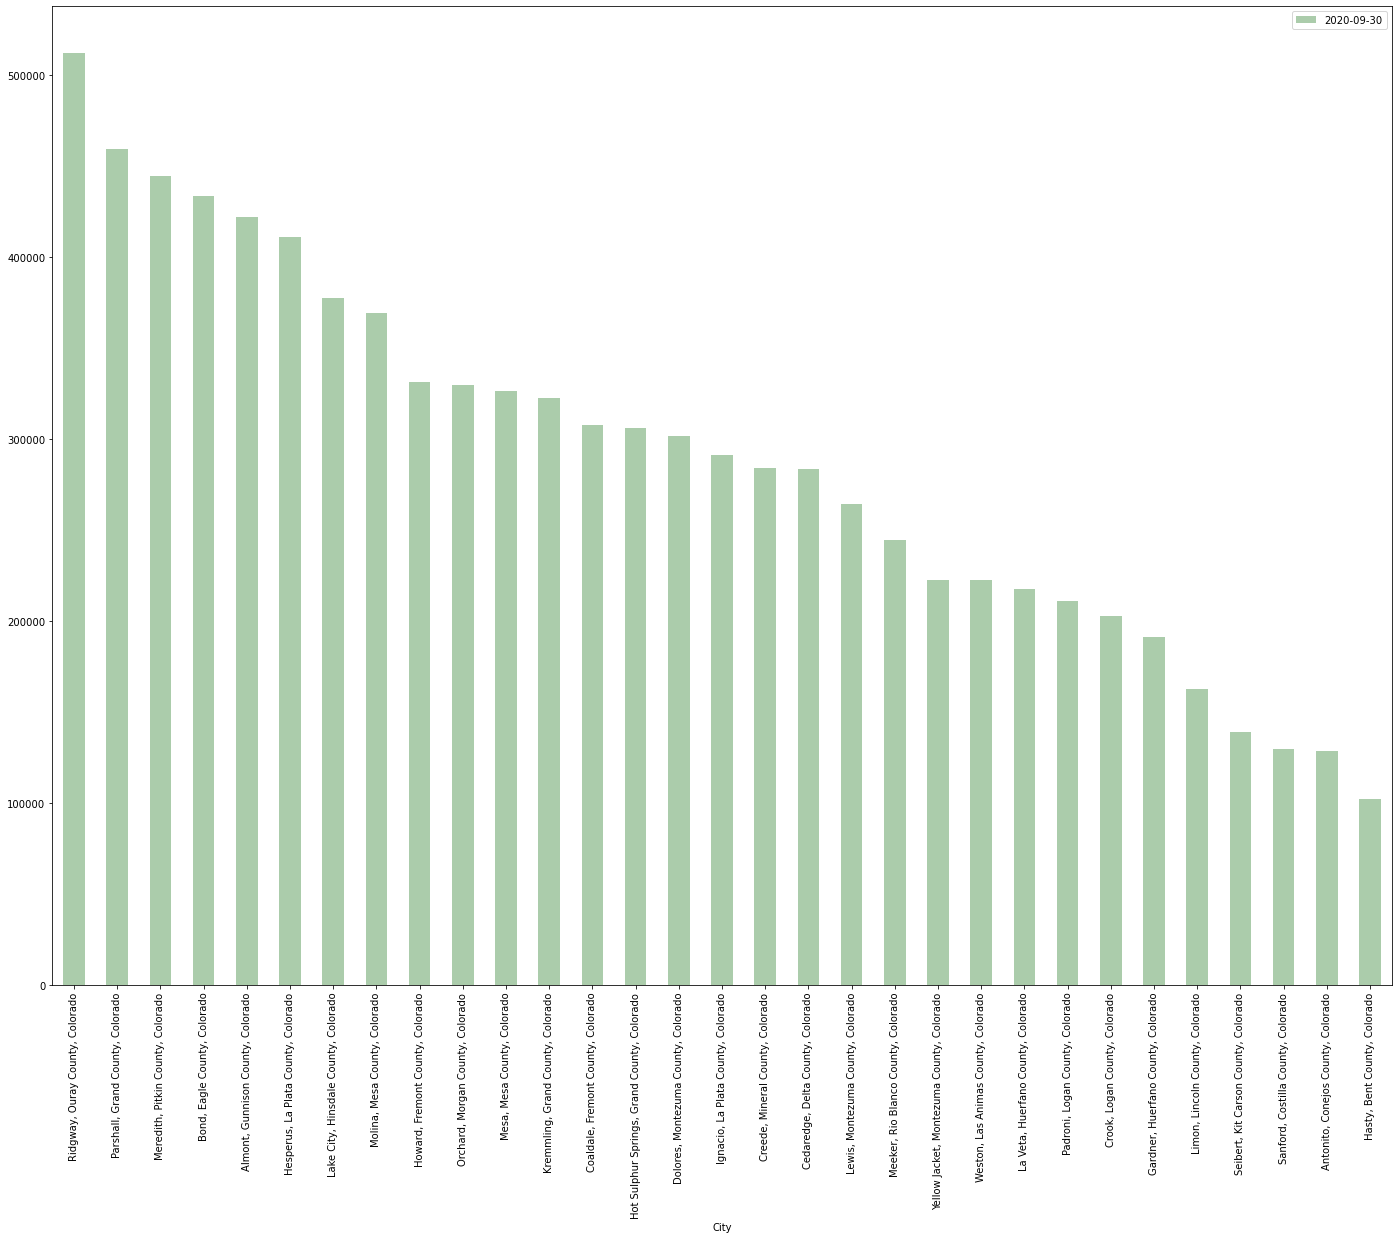

In [100]:
cluster0hv.plot(kind='bar', color='darkseagreen', figsize=(24,18),alpha=0.75)
plt.savefig('cluster0hv.png', bbox_inches='tight')

#### Cluster 1 Rivers & Rafting

In [63]:
cluster1 = co_merged2.loc[co_merged2['Cluster Labels'] == 1]
cluster1

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
92,"Romeo, Conejos County, Colorado",37.172233,-105.985300,74325.0,1.0,River,Windmill,Paintball Field,Nature Preserve
96,"De Beque, Mesa County, Colorado",39.334775,-108.215286,238358.0,1.0,River,Mountain,Windmill,Paintball Field
108,"Cotopaxi, Fremont County, Colorado",38.370275,-105.688059,239765.0,1.0,River,Trail,Rafting,Campground
138,"San Luis, Costilla County, Colorado",37.201236,-105.423769,95019.0,1.0,River,Sculpture Garden,Windmill,Fishing Spot
148,"Stratton, Kit Carson County, Colorado",39.303328,-102.604645,138477.0,1.0,River,Windmill,Paintball Field,Nature Preserve
172,"Aguilar, Las Animas County, Colorado",37.402793,-104.653319,135975.0,1.0,Trail,River,Windmill,Farm
190,"Iliff, Logan County, Colorado",40.759156,-103.066589,215608.0,1.0,River,Farm,Paintball Field,Nature Preserve
221,"Vona, Kit Carson County, Colorado",39.303604,-102.742983,131585.0,1.0,River,Windmill,Paintball Field,Nature Preserve


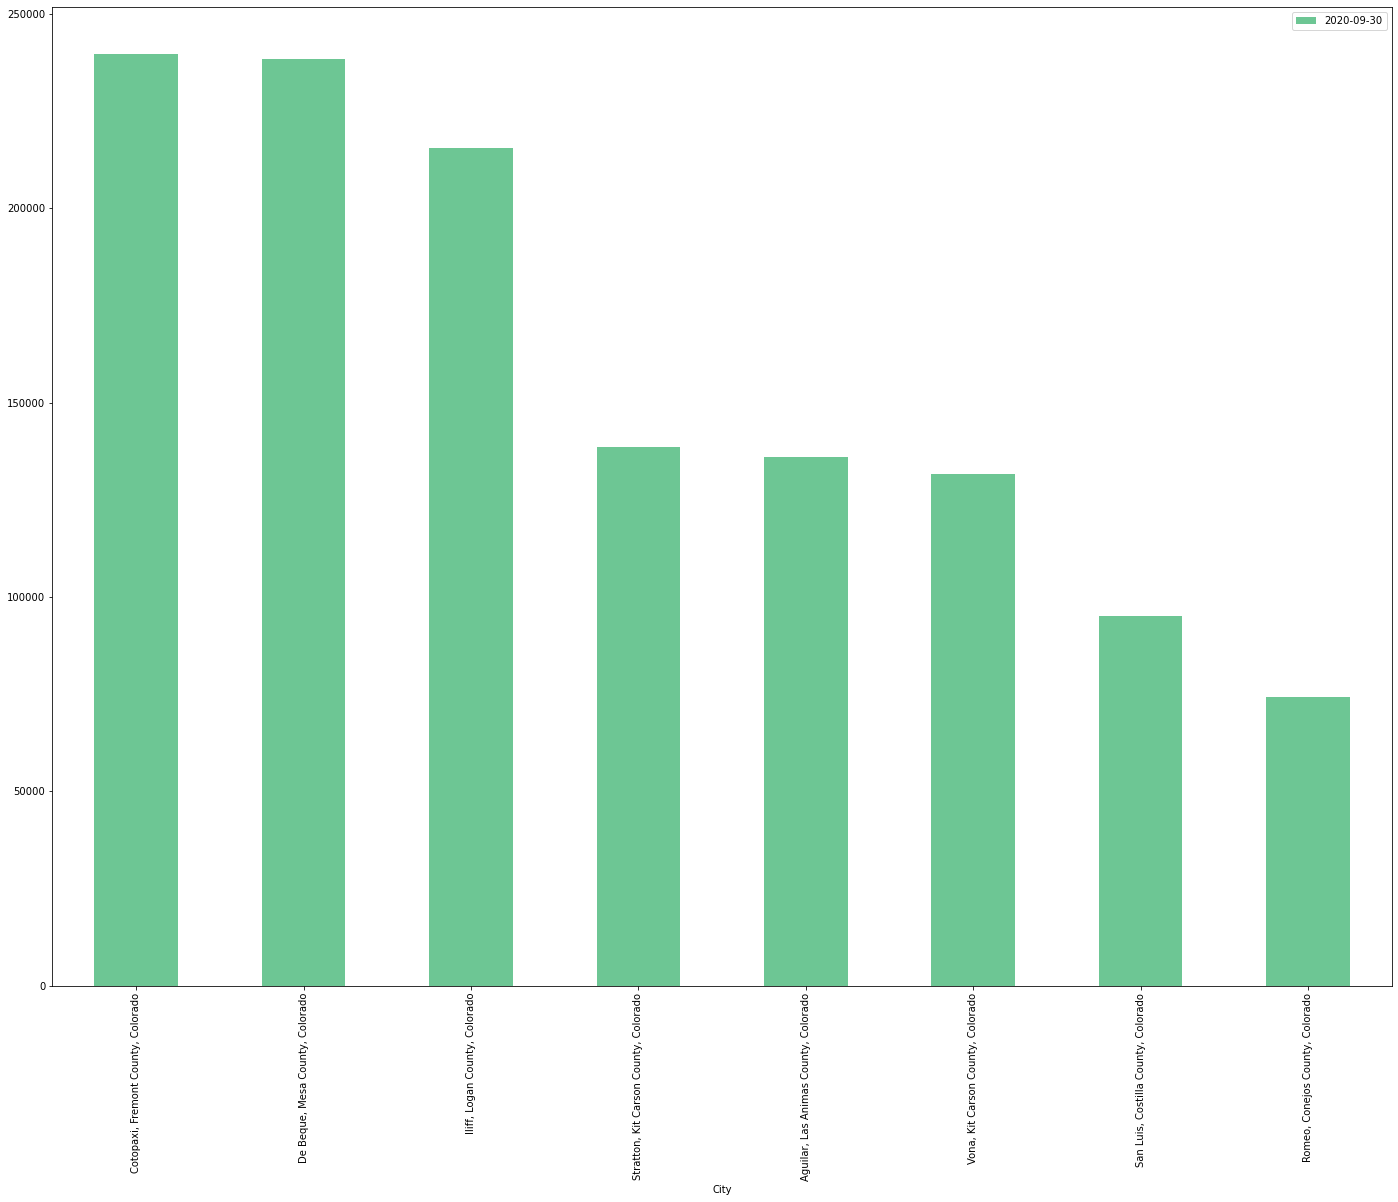

In [101]:
cluster1hv = cluster1[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster1hv.set_index('City', inplace=True)
cluster1hv.plot(kind='bar', color='mediumseagreen', figsize=(24,18),alpha=0.75)
plt.savefig('cluster1hv.png', bbox_inches='tight')

#### Cluster2 

In [67]:
cluster2 = co_merged2.loc[co_merged2['Cluster Labels'] == 2]
cluster2

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
4,"Canon City, Fremont County, Colorado",38.442364,-105.222495,239582.0,2.0,Park,Athletics & Sports,Tree,Trail
8,"Sterling, Logan County, Colorado",40.625541,-103.207709,180273.0,2.0,Park,Ski Area,Paintball Field,Nature Preserve
11,"Cortez, Montezuma County, Colorado",37.349453,-108.584074,216005.0,2.0,Park,National Park,Campground,Fishing Spot
12,"Alamosa, Alamosa County, Colorado",37.469877,-105.869600,188761.0,2.0,Park,Trail,Campground,Farm
17,"Clifton, Mesa County, Colorado",39.080073,-108.459277,211351.0,2.0,Park,Trail,Athletics & Sports,Tree
18,"Rifle, Garfield County, Colorado",39.534702,-107.783120,316683.0,2.0,Park,Rafting,Paintball Field,Nature Preserve
19,"Craig, Moffat County, Colorado",40.515249,-107.546454,192651.0,2.0,Park,Athletics & Sports,Plaza,Beach
25,"La Junta, Otero County, Colorado",37.985009,-103.543832,101644.0,2.0,Park,Campground,Fishing Spot,Outdoors & Recreation
27,"Gunnison, Gunnison County, Colorado",38.545825,-106.925321,360800.0,2.0,Park,Campground,Fishing Spot,Athletics & Sports
30,"Bayfield, La Plata County, Colorado",37.225559,-107.598112,334749.0,2.0,Park,Campground,Mountain,River


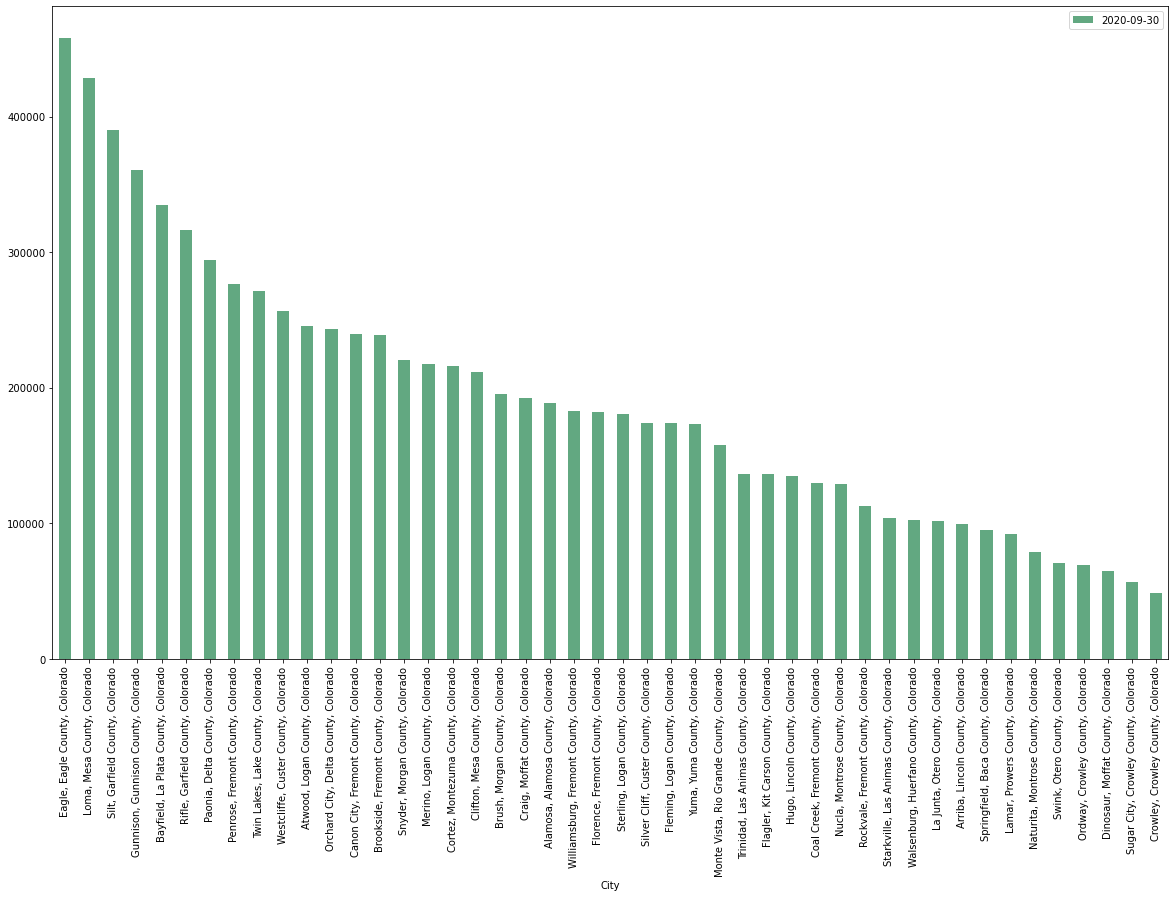

In [102]:
cluster2hv = cluster2[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster2hv.set_index('City', inplace=True)
cluster2hv.sort_values(by=['2020-09-30'])
cluster2hv.plot(kind='bar', color='seagreen', figsize=(20,12),alpha=0.75)
plt.savefig('cluster2hv.png', bbox_inches='tight')

#### Cluster 3

In [69]:
cluster3 = co_merged2.loc[co_merged2['Cluster Labels'] == 3]
cluster3

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
47,"Rocky Ford, Otero County, Colorado",38.052508,-103.720227,90894.0,3.0,Farm,Park,Lake,Stables
50,"Burlington, Kit Carson County, Colorado",39.304791,-102.269239,181046.0,3.0,Farm,Campground,Park,Beach
57,"Olathe, Montrose County, Colorado",38.604985,-107.982288,245451.0,3.0,Park,Farm,Athletics & Sports,Beach
64,"Del Norte, Rio Grande County, Colorado",37.678892,-106.353368,179663.0,3.0,Farm,Waterfall,Outdoors & Recreation,Nature Preserve
91,"Wiggins, Morgan County, Colorado",40.230536,-104.072728,300265.0,3.0,Farm,Lake,Scenic Lookout,Paintball Field
93,"Fowler, Otero County, Colorado",38.129172,-104.023293,101572.0,3.0,Farm,Park,Athletics & Sports,Beach
122,"Genoa, Lincoln County, Colorado",39.278321,-103.500224,158803.0,3.0,Farm,Mountain,Scenic Lookout,Paintball Field
128,"Olney Springs, Crowley County, Colorado",38.166116,-103.944679,85509.0,3.0,Park,Farm,Athletics & Sports,Beach
135,"Dove Creek, Dolores County, Colorado",37.764989,-108.899566,98293.0,3.0,Farm,Mountain,Waterfall,Outdoors & Recreation
139,"Mosca, Alamosa County, Colorado",37.651236,-105.871185,171320.0,3.0,Farm,Scenic Lookout,Paintball Field,Nature Preserve


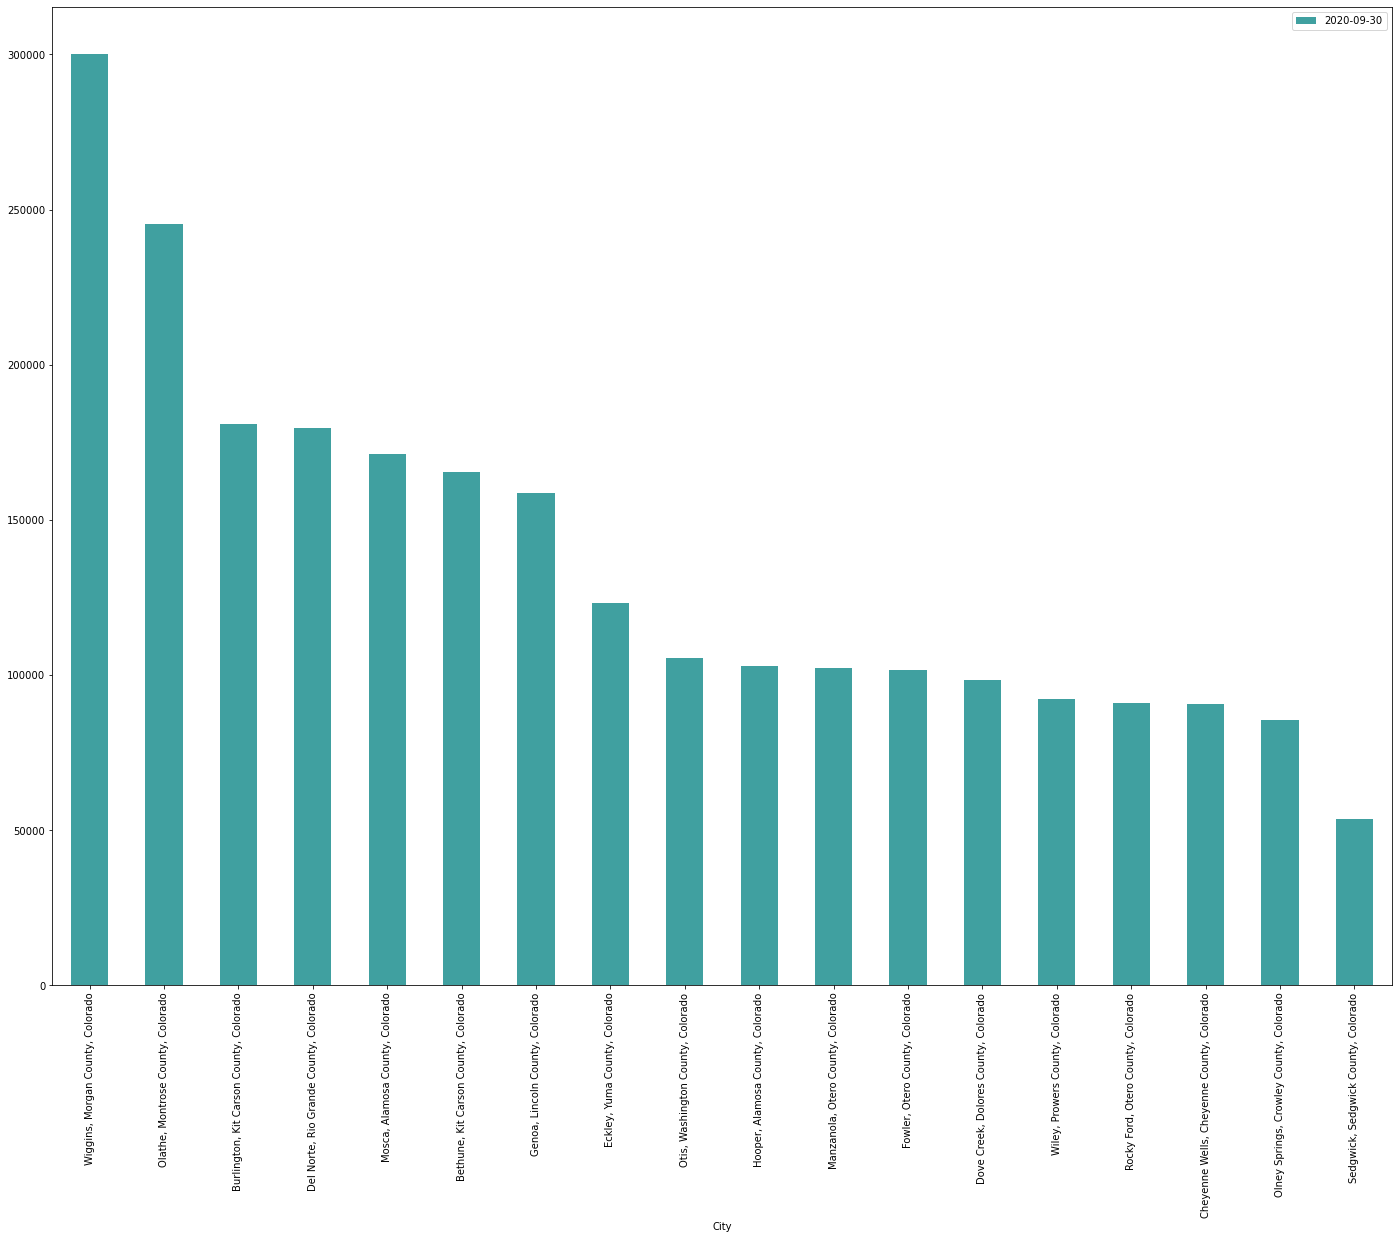

In [103]:
cluster3hv = cluster3[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster3hv.set_index('City', inplace=True)
cluster3hv.plot(kind='bar', color='teal', figsize=(24,18),alpha=0.75)
plt.savefig('cluster3hv.png', bbox_inches='tight')

#### Cluster 4

In [73]:
cluster4 = co_merged2.loc[co_merged2['Cluster Labels'] == 4]
cluster4

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Grand Junction, Mesa County, Colorado",39.063956,-108.550732,272388.0,4.0,Trail,Park,Athletics & Sports,Climbing Gym
2,"Durango, La Plata County, Colorado",37.271395,-107.881598,464640.0,4.0,Park,Rafting,Trail,Tree
3,"Montrose, Montrose County, Colorado",38.478193,-107.876277,298473.0,4.0,Athletics & Sports,Tree,Park,Trail
7,"Steamboat Springs, Routt County, Colorado",40.484800,-106.831736,670768.0,4.0,Ski Area,Park,Ski Trail,Trail
9,"Fort Morgan, Morgan County, Colorado",40.250258,-103.799951,225409.0,4.0,Athletics & Sports,Pool,Windmill,Fishing Spot
...,...,...,...,...,...,...,...,...,...
254,"Parlin, Gunnison County, Colorado",38.503036,-106.729428,302446.0,4.0,Hot Spring,Windmill,Waterfall,Outdoors & Recreation
257,"Log Lane Village, Morgan County, Colorado",40.270536,-103.829673,107117.0,4.0,Athletics & Sports,Pool,Windmill,Fishing Spot
258,"Poncha Springs, Chaffee County, Colorado",38.513969,-106.075332,311275.0,4.0,Athletics & Sports,Trail,Park,Rafting
261,"Rico, Dolores County, Colorado",37.692686,-108.031502,280722.0,4.0,Mountain,Hot Spring,Windmill,Waterfall


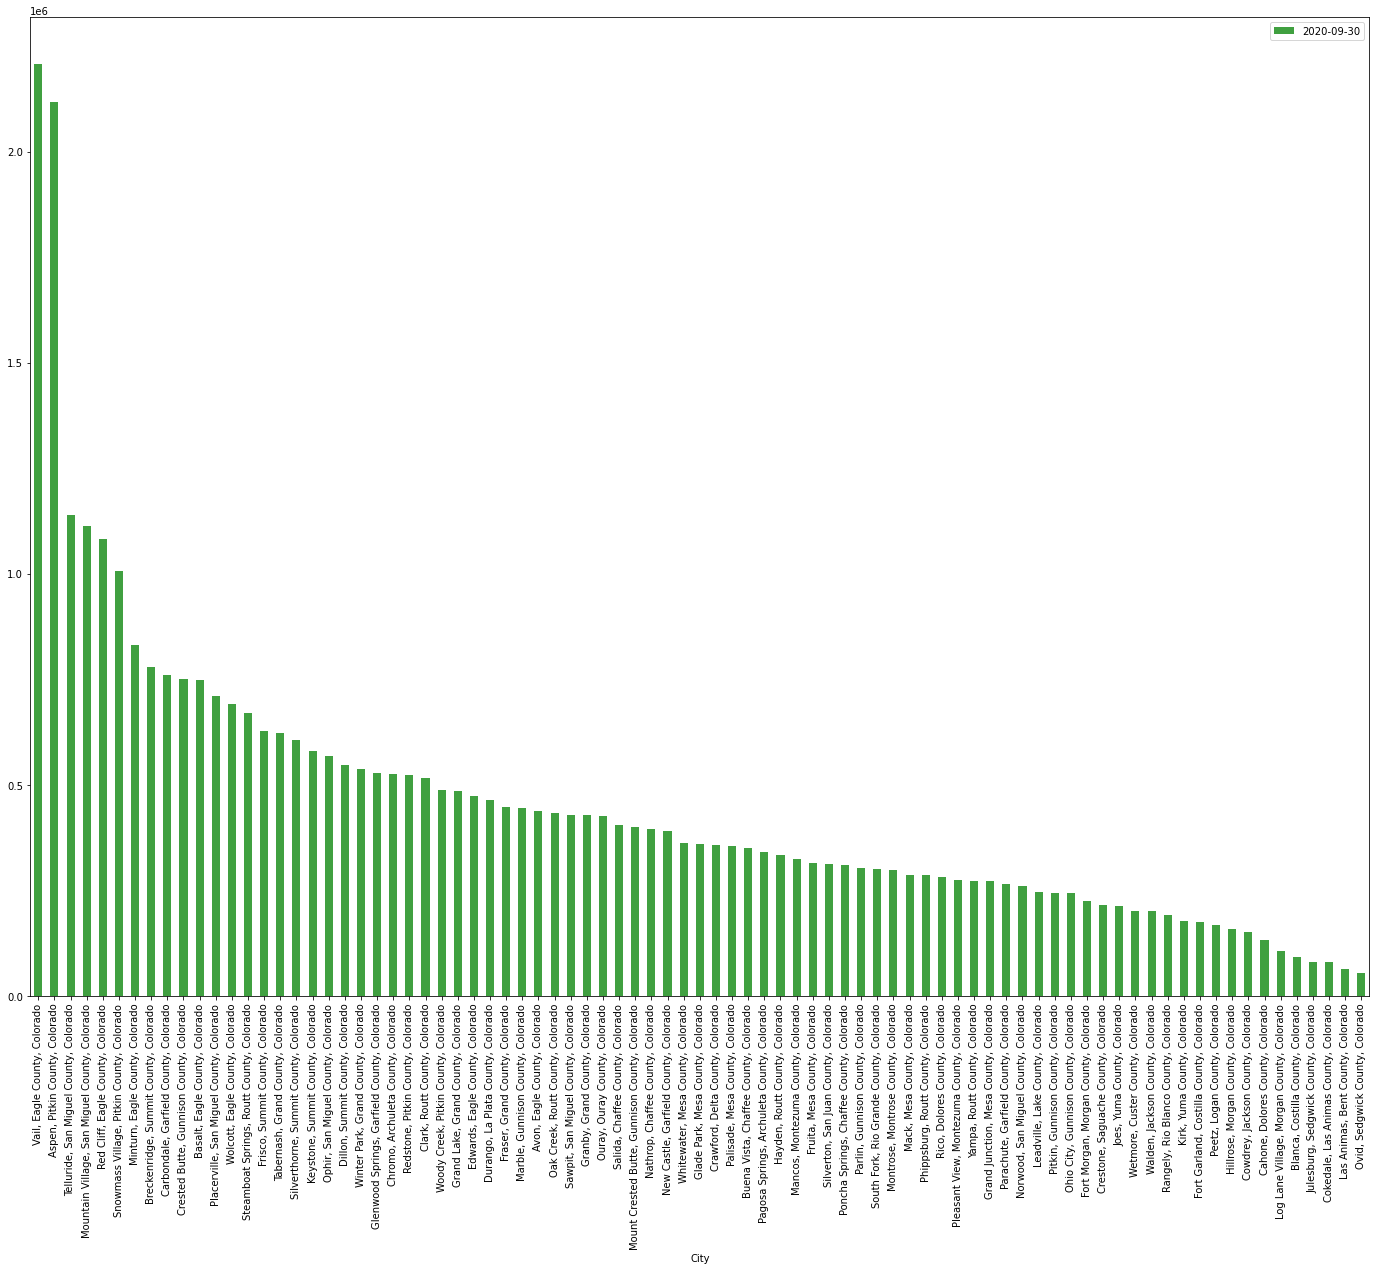

In [104]:
cluster4hv = cluster4[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster4hv.set_index('City', inplace=True)
cluster4hv.plot(kind='bar', color='green', figsize=(24,18),alpha=0.75)
plt.savefig('cluster4hv.png', bbox_inches='tight')

#### Cluster 5

In [74]:
cluster5 = co_merged2.loc[co_merged2['Cluster Labels'] == 5]
cluster5

,City,Lat,Lon,2020-09-30,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
16,"Delta, Delta County, Colorado",38.743612,-108.072917,227652.0,5.0,Park,Tree,Farm,Nature Preserve
20,"Gypsum, Eagle County, Colorado",39.646929,-106.951711,364348.0,5.0,Tree,Windmill,Farm,Nature Preserve
65,"Hotchkiss, Delta County, Colorado",38.799707,-107.719503,318752.0,5.0,Tree,Windmill,Farm,Nature Preserve
105,"Holly, Prowers County, Colorado",38.052230,-102.123030,64155.0,5.0,Park,Tree,Farm,Nature Preserve
177,"Saguache, Saguache County, Colorado",38.087539,-106.142084,151670.0,5.0,Tree,Windmill,Farm,Nature Preserve


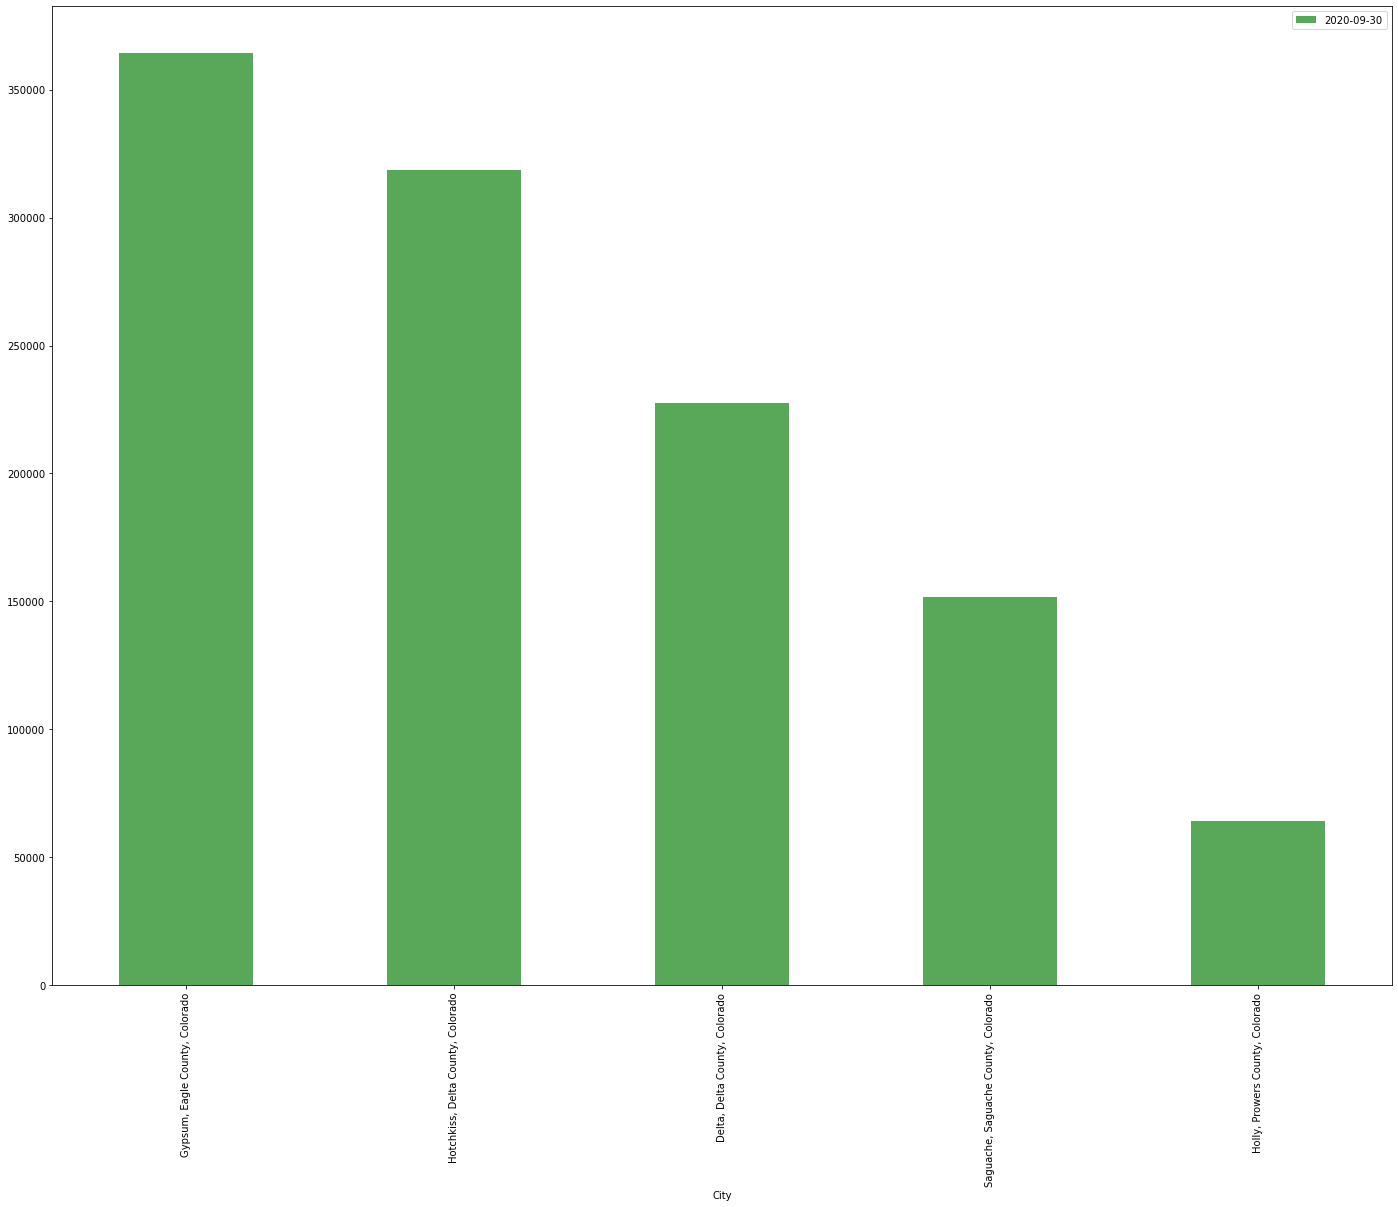

In [105]:
cluster5hv = cluster5[['City', '2020-09-30']].sort_values('2020-09-30', ascending=False)
cluster5hv.set_index('City', inplace=True)
cluster5hv.plot(kind='bar', color='forestgreen', figsize=(24,18),alpha=0.75)
plt.savefig('cluster5hv.png', bbox_inches='tight')